In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read Me


As the MFCC classification takes lot of execution time, I have shared the json file which already has the extracted feautures. Please use it to directly load the inputs. Path to the jsonfile : https://drive.google.com/file/d/1kLIBm9q2843BbMh1lWJR-GTKDCQLLpfl/view?usp=sharing


In [ ]:
pip install soundfile

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import soundfile as sf
import librosa
import librosa.display
from IPython.display import Audio
from tqdm import tqdm 

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LSTM, Bidirectional, GRU, BatchNormalization, LeakyReLU
from keras.utils import to_categorical

import os
import math
import json
import random

import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Waveform

In [ ]:
#Load a single music sample and check its attributes and graphs
signal, sample_rate = librosa.load('/content/drive/MyDrive/MusicGenreClassification/Data/genres_original/classical/classical.00013.wav', sr=22050)
print('Length of Signal is ', len(signal))
print('Sampling Rateis ', sample_rate)
print('Duration of the audio file is', len(signal)/sample_rate, ' seconds')

Length of Signal is  661794
Sampling Rateis  22050
Duration of the audio file is 30.013333333333332  seconds


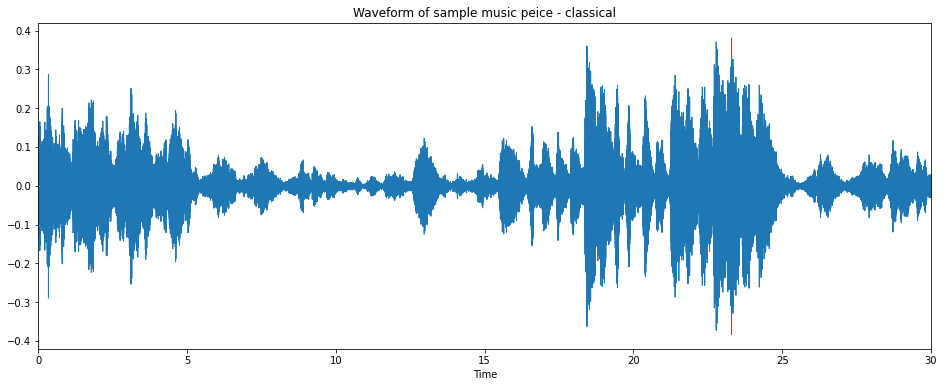

In [ ]:
#Plot the waveform of the signal wrt time
plt.figure(figsize=(16, 6))
librosa.display.waveplot(y=signal, sr=sample_rate)
plt.title("Waveform of sample music peice - classical", fontsize=12)
plt.show()

#Spectogram

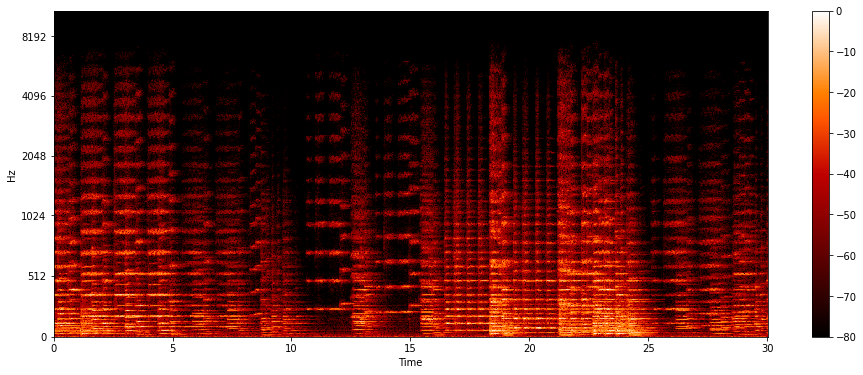

In [ ]:
#Drawing a spectogram for the same sample
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns

# Short-time Fourier transform (STFT)
D = np.abs(librosa.stft(signal, n_fft=n_fft, hop_length=hop_length))

# Convert an amplitude spectrogram to Decibels-scaled spectrogram.
db = librosa.amplitude_to_db(D, ref=np.max)

plt.figure(figsize = (16, 6))
librosa.display.specshow(db, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='mel',
                        cmap='gist_heat')
plt.colorbar();


#Genrate MFCC

In [ ]:
def extract_sound_data(dataset_path, json_path, n_mfcc=13, n_fft=4084, hop_length=1024, num_segments=10):
    #Store the mfcc and labels in a structure
    data = {
        'mfcc' : [],
        'labels' : []
    }
    
    count = 0
    num_samples_per_segment = int(sample_rate*30 / num_segments) 
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)
    
    #Loop through all the genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath not in dataset_path:
            dirpath_components = dirpath.split('/')
            semantic_label = dirpath_components[-1]
            print('\nProcessing {}'.format(semantic_label))
            
            #process files for a specific genre 
            for f in filenames:
                if f.endswith('.wav') and f != 'jazz.00054.wav': # Since file jazz.00054.wav is an empty file
                    
                    file_path = os.path.join(dirpath,f)
                    signal, sr = sf.read(file_path)
                    for s in range(num_segments): 
                        start_sample = num_samples_per_segment * s   
                        finish_sample = num_samples_per_segment + start_sample
                        mfcc = librosa.feature.mfcc(signal[start_sample : finish_sample],
                                                   sr = sr,
                                                   n_fft = n_fft,
                                                   n_mfcc = n_mfcc,
                                                   hop_length = hop_length)

                        mfcc = mfcc.T
                        if len(mfcc) == expected_num_mfcc_vectors_per_segment:
                            print(mfcc.shape)
                            data['mfcc'].append(mfcc.tolist())
                            data['labels'].append(i)
                            print('Processing {}, segment:{}'.format(file_path, s))
                            count += 1
                            print(count)
    with open(json_path, 'w') as fp:
        json.dump(data, fp, indent=4)

In [ ]:
#Extract the feautures using mfcc and store in json file
extract_sound_data('/content/drive/MyDrive/MusicGenreClassification/Data/genres_original/', './myjson.json')

Streaming output truncated to the last 5000 lines.
(65, 13)
Processing /content/drive/MyDrive/MusicGenreClassification/Data/genres_original/rock/rock.00023.wav, segment:4
8324
(65, 13)
Processing /content/drive/MyDrive/MusicGenreClassification/Data/genres_original/rock/rock.00023.wav, segment:5
8325
(65, 13)
Processing /content/drive/MyDrive/MusicGenreClassification/Data/genres_original/rock/rock.00023.wav, segment:6
8326
(65, 13)
Processing /content/drive/MyDrive/MusicGenreClassification/Data/genres_original/rock/rock.00023.wav, segment:7
8327
(65, 13)
Processing /content/drive/MyDrive/MusicGenreClassification/Data/genres_original/rock/rock.00023.wav, segment:8
8328
(65, 13)
Processing /content/drive/MyDrive/MusicGenreClassification/Data/genres_original/rock/rock.00023.wav, segment:9
8329
(65, 13)
Processing /content/drive/MyDrive/MusicGenreClassification/Data/genres_original/rock/rock.00034.wav, segment:0
8330
(65, 13)
Processing /content/drive/MyDrive/MusicGenreClassification/Data/g

In [ ]:
#Save this file for future use. 
from shutil import copyfile
copyfile('/content/myjson.json', '/content/drive/MyDrive/MusicGenreClassification/MGC.json')

'/content/drive/MyDrive/MusicGenreClassification/MGC.json'

Start the execution of the program from here, If you want to use the json file. If not, please change the path to load your own json file. 

In [ ]:
# Load the previously stored json file
def load_data(path):
    with open(path, 'r') as dataset:
        musicdata = json.load(dataset)
        
    #Convert lists into numpy arrays
    inputs = musicdata['mfcc']
    targets = musicdata['labels'] 
    return np.array(inputs), np.array(targets)

In [ ]:
X, Y = load_data('/content/drive/MyDrive/MusicGenreClassification/MGC.json')

In [ ]:
#Check the shape of the data
X.shape

(9989, 65, 13)

In [ ]:
#Check for the target values
np.unique(Y, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([1000, 1000, 1000,  990, 1000, 1000,  999, 1000, 1000, 1000]))

In [ ]:
# Convert the labels from 1-10 to 0-9
v = min(np.unique(Y))
for i in range(len(Y)):
  Y[i] = Y[i] - v

In [ ]:
np.unique(Y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1000, 1000, 1000,  990, 1000, 1000,  999, 1000, 1000, 1000]))

In [ ]:
#Split the data into train-test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)

#Deep Learning Models

#RNN

In [ ]:
rnnmodel = Sequential()

rnnmodel.add(GRU(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
rnnmodel.add(GRU(500, return_sequences=True))
rnnmodel.add(GRU(1000))
rnnmodel.add(LeakyReLU())
rnnmodel.add(Dropout(0.2))
rnnmodel.add(BatchNormalization())
rnnmodel.add(Flatten())
rnnmodel.add(Dense(100))
rnnmodel.add(LeakyReLU())
rnnmodel.add(Dense(10, 'softmax'))

rnnmodel.compile(optimizer=tf.keras.optimizers.Adam(),
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
rnnmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 65, 100)           34500     
_________________________________________________________________
gru_1 (GRU)                  (None, 65, 500)           903000    
_________________________________________________________________
gru_2 (GRU)                  (None, 1000)              4506000   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1000)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1000)              4000      
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0

In [ ]:
resultrnn = rnnmodel.fit(X_train, Y_train,
            validation_data=(X_test, Y_test),
            epochs = 10,
            batch_size=100)#100

Epoch 1/10
80/80 [==============================] - 443s 6s/step - loss: 1.6244 - accuracy: 0.4566 - val_loss: 1.5902 - val_accuracy: 0.4730
Epoch 2/10
80/80 [==============================] - 441s 6s/step - loss: 1.1572 - accuracy: 0.5925 - val_loss: 1.2483 - val_accuracy: 0.5415
Epoch 3/10
80/80 [==============================] - 444s 6s/step - loss: 0.9210 - accuracy: 0.6799 - val_loss: 1.0460 - val_accuracy: 0.6587
Epoch 4/10
80/80 [==============================] - 447s 6s/step - loss: 0.7769 - accuracy: 0.7189 - val_loss: 0.8931 - val_accuracy: 0.6877
Epoch 5/10
80/80 [==============================] - 444s 6s/step - loss: 0.6465 - accuracy: 0.7745 - val_loss: 0.8743 - val_accuracy: 0.7117
Epoch 6/10
80/80 [==============================] - 444s 6s/step - loss: 0.5346 - accuracy: 0.8137 - val_loss: 0.7872 - val_accuracy: 0.7362
Epoch 7/10
80/80 [==============================] - 444s 6s/step - loss: 0.4539 - accuracy: 0.8388 - val_loss: 0.8128 - val_accuracy: 0.7402
Epoch 8/10
80

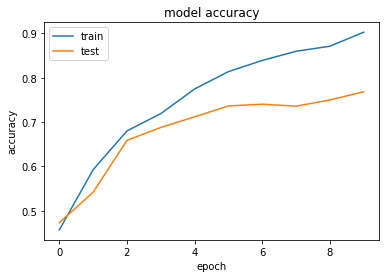

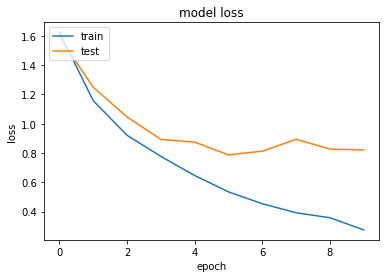

In [ ]:
plt.plot(resultrnn.history['accuracy'])
plt.plot(resultrnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(resultrnn.history['loss'])
plt.plot(resultrnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

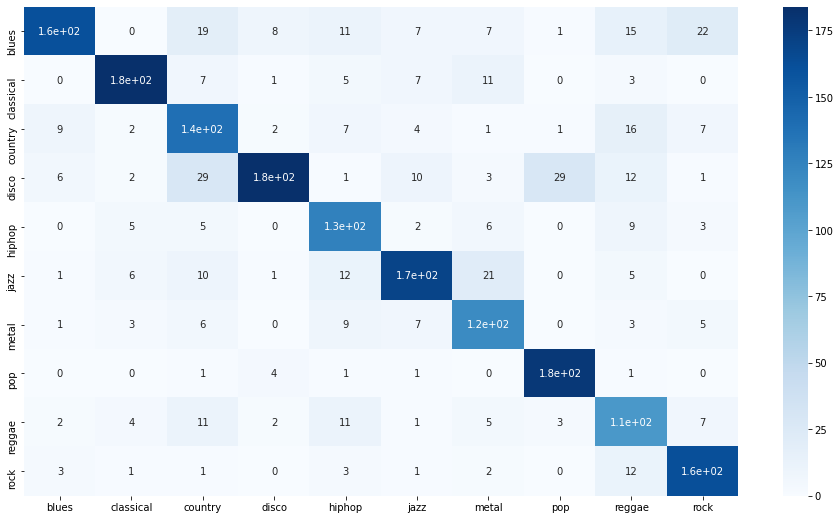

In [ ]:
#Printing the confusion matrix
y_pred = rnnmodel.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
confusion_matrix = metrics.confusion_matrix(y_pred, Y_test) 
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matrix, cmap="Blues", annot=True, 
                xticklabels = ["blues", "classical", "country", "disco", 
                               "hiphop", "jazz", "metal", "pop", "reggae", "rock"], 
                yticklabels=["blues", "classical", "country", "disco", "hiphop", 
                             "jazz", "metal", "pop", "reggae", "rock"])
plt.show()


#CNN

In [ ]:
X_train_cnn = X_train[...,np.newaxis]
X_test_cnn = X_test[...,np.newaxis] 

In [ ]:
input_shape = (X_train_cnn.shape[1],X_train_cnn.shape[2],X_train_cnn.shape[3])

cnnmodel = keras.Sequential()
cnnmodel.add(keras.layers.Conv2D(32 , (3,3) ,activation = 'relu', input_shape=input_shape))
cnnmodel.add(keras.layers.MaxPooling2D((3,3),strides=(2,2),padding='same'))
cnnmodel.add(keras.layers.BatchNormalization())

cnnmodel.add(keras.layers.Conv2D(64 , (3,3) ,activation = 'relu'))
cnnmodel.add(keras.layers.MaxPooling2D((3,3),strides=(2,2),padding='same'))
cnnmodel.add(keras.layers.BatchNormalization())
    
cnnmodel.add(keras.layers.Conv2D(120 , (2,2) ,activation = 'relu'))
cnnmodel.add(keras.layers.MaxPooling2D((2,2),strides=(2,2),padding='same'))
cnnmodel.add(keras.layers.BatchNormalization())
    
cnnmodel.add(keras.layers.Flatten())
cnnmodel.add(keras.layers.Dense(64,activation = 'relu'))
cnnmodel.add(keras.layers.Dropout(0.3))
cnnmodel.add(keras.layers.Dense(10,activation='softmax'))


In [ ]:
optimizer =  keras.optimizers.Adam(learning_rate=0.001)
cnnmodel.compile(optimizer = optimizer ,loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])
resultcnn = cnnmodel.fit(X_train_cnn, Y_train, validation_data=(X_test_cnn, Y_test),batch_size=32,epochs=32)

Epoch 1/32
250/250 [==============================] - 10s 39ms/step - loss: 1.5449 - accuracy: 0.4715 - val_loss: 1.1875 - val_accuracy: 0.5701
Epoch 2/32
250/250 [==============================] - 10s 39ms/step - loss: 1.1171 - accuracy: 0.6039 - val_loss: 1.1265 - val_accuracy: 0.6216
Epoch 3/32
250/250 [==============================] - 10s 38ms/step - loss: 0.9212 - accuracy: 0.6781 - val_loss: 0.9372 - val_accuracy: 0.6802
Epoch 4/32
250/250 [==============================] - 10s 39ms/step - loss: 0.8135 - accuracy: 0.7199 - val_loss: 0.8622 - val_accuracy: 0.7012
Epoch 5/32
250/250 [==============================] - 10s 38ms/step - loss: 0.7217 - accuracy: 0.7485 - val_loss: 0.7560 - val_accuracy: 0.7417
Epoch 6/32
250/250 [==============================] - 10s 38ms/step - loss: 0.6512 - accuracy: 0.7731 - val_loss: 0.8844 - val_accuracy: 0.6922
Epoch 7/32
250/250 [==============================] - 10s 39ms/step - loss: 0.5603 - accuracy: 0.7999 - val_loss: 0.6871 - val_accuracy:

<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fa8c1e68b38>>

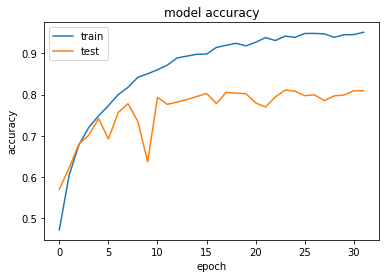

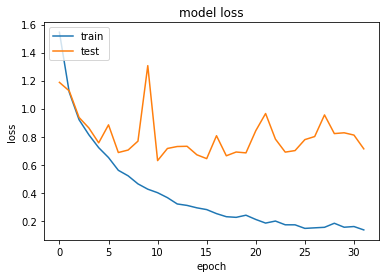

In [ ]:
plt.plot(resultcnn.history['accuracy'])
plt.plot(resultcnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(resultcnn.history['loss'])
plt.plot(resultcnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

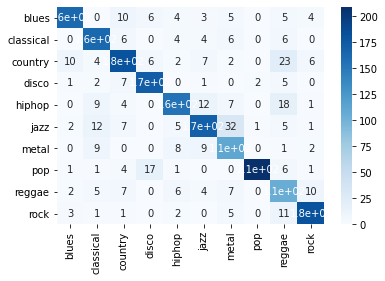

In [ ]:
#Confusion matrix for validation data
y_pred = cnnmodel.predict(X_test_cnn)
y_pred = np.argmax(y_pred, axis=1)
confusion_matrix = metrics.confusion_matrix(y_pred, Y_test) 
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matrix, cmap="Blues", annot=True, 
                xticklabels = ["blues", "classical", "country", "disco", 
                               "hiphop", "jazz", "metal", "pop", "reggae", "rock"], 
                yticklabels=["blues", "classical", "country", "disco", "hiphop", 
                             "jazz", "metal", "pop", "reggae", "rock"])
plt.show()

#Traditional Learning Models

In [ ]:
input_width = X_train.shape[1]
input_height = X_train.shape[2]

def reformat(dataset):
    dataset = dataset.reshape(
        (-1, input_width * input_height)).astype(np.float32)
    return dataset

In [ ]:
#Reformatting the data by vectorizing it
inputs_train = reformat(X_train)
inputs_test = reformat(X_test)

In [ ]:
inputs_train.shape

(7991, 845)

In [ ]:
#PCA to reduce the dimensionality

pca = PCA(copy=True, iterated_power='auto', n_components=800, random_state=None,
          svd_solver='auto', tol=0.0, whiten=False)
pca.fit(inputs_train)

train_data = pca.transform(inputs_train)
test_data = pca.transform(inputs_test)

print("Shape of training set after pca:")
print(train_data.shape)

print("Shape of testing set after pca:")
print(test_data.shape)

Shape of training set after pca:
(7991, 800)
Shape of testing set after pca:
(1998, 800)


SVM

Can skip this step.

In [ ]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'C': [0.1, 1, 10]},
                    {'kernel': ['linear'], 'C': [0.1, 1, 10]},
                    {'kernel': ['poly'], 'C': [0.1, 1, 10]}]
# Check for the best parameters                    
svmclassifier = GridSearchCV(
        SVC(), tuned_parameters, cv = 5
    )
svmclassifier.fit(train_data, Y_train)
print("Best parameters to train are: ", svmclassifier.best_params_)

Best parameters to train are:  {'C': 10, 'kernel': 'rbf'}


In [ ]:
svmmodel = SVC(C=10)#kernel = rbf, C =10

# training SVM
svmmodel.fit(train_data, Y_train)

# getting predictions of training set
train_predictions_svm = svmmodel.predict(train_data)


In [ ]:
print("SVM : Accuracy score for training data is ", accuracy_score(Y_train, train_predictions_svm))

SVM : Accuracy score for training data is  0.9747215617569766


In [ ]:
test_predictions_svm = svmmodel.predict(test_data)
print("SVM : Accuracy score for testing data is", accuracy_score(Y_test, test_predictions_svm))

SVM : Accuracy score for testing data is 0.6876876876876877


KNN

In [ ]:
knnmodel = KNeighborsClassifier(n_neighbors=3)
knnmodel.fit(train_data, Y_train)
train_predictions_knn = knnmodel.predict(train_data)
print("KNN : Accuracy score for training data is ", accuracy_score(Y_train, train_predictions_knn))

KNN : Accuracy score for training data is  0.7158052809410587


In [ ]:
test_predictions_knn = knnmodel.predict(test_data)
print("KNN : Accuracy score for testing data is ", accuracy_score(Y_test, test_predictions_knn))

KNN : Accuracy score for testing data is  0.4944944944944945
